# Script to train the ML model

In [248]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set seed for reproducability
#torch.manual_seed(42)

Train size:  2457
Validation size:  819
Test size:  820


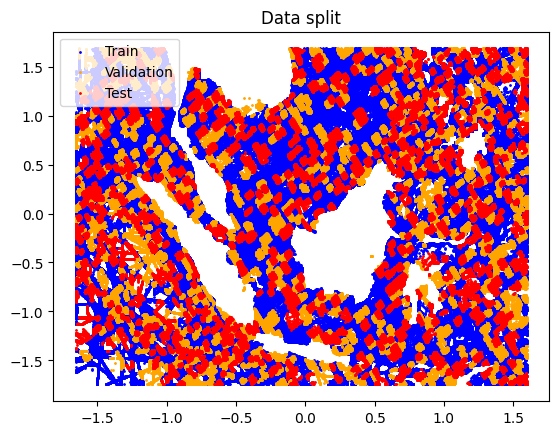

In [249]:
# load data
data = np.load("../data/processed/data.npy")
target = np.load("../data/processed/target.npy")

# Normalize data
data_means = data.mean(axis=(0, 1))
data_stds = data.std(axis=(0, 1))
data = (data - data_means) / data_stds

target_mean = target.mean()
target_std = target.std()
target = (target - target_mean) / target_std


# Get constants
n_data = data.shape[0]
n_batchsize = data.shape[1]
n_features = data.shape[2]

# convert to torch tensors
data = torch.tensor(data, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

# Setup data-split
train_size = int(0.6 * n_data)
validation_size = int(0.2 * n_data)
test_size = len(data) - train_size - validation_size
print("Train size: ", train_size)
print("Validation size: ", validation_size)
print("Test size: ", test_size)

# Shuffle data
shuffle_idx = torch.randperm(n_data)
data = data[shuffle_idx]
target = target[shuffle_idx]

# Split data
train_x = data[:train_size]
train_y = target[:train_size]
validation_x = data[train_size:train_size+validation_size]
validation_y = target[train_size:train_size+validation_size]
test_x = data[train_size+validation_size:]
test_y = target[train_size+validation_size:]

# Show how the data is distributed
plt.scatter(train_x[:,:,0].reshape(-1), train_x[:,:,1].reshape(-1), 1, "b", label="Train")
plt.scatter(validation_x[:,:,0].reshape(-1), validation_x[:,:,1].reshape(-1), 1, "orange", label="Validation")
plt.scatter(test_x[:,:,0].reshape(-1), test_x[:,:,1].reshape(-1), 1, "red", label="Test")
plt.title("Data split")
plt.legend()

In [250]:
# Setup dataloaders
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_x, validation_y)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [251]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 258), 
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(258, 258),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(258, 258),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(258, 258),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(258, 1)
    )

  def forward(self, X):
    return self.net(X)

  def predict(self, X):
    Y_pred = self.forward(X)
    return Y_pred

Epoch: 0
Epoch: 0, minibatch 2457, loss: 0.337, validation-loss: 0.323
Epoch: 1
Epoch: 1, minibatch 2457, loss: 0.317, validation-loss: 0.304
Epoch: 2
Epoch: 2, minibatch 2457, loss: 0.308, validation-loss: 0.294
Epoch: 3
Epoch: 3, minibatch 2457, loss: 0.299, validation-loss: 0.287
Epoch: 4
Epoch: 4, minibatch 2457, loss: 0.298, validation-loss: 0.288
Epoch: 5
Epoch: 5, minibatch 2457, loss: 0.293, validation-loss: 0.280
Epoch: 6
Epoch: 6, minibatch 2457, loss: 0.289, validation-loss: 0.279
Epoch: 7
Epoch: 7, minibatch 2457, loss: 0.287, validation-loss: 0.277
Epoch: 8
Epoch: 8, minibatch 2457, loss: 0.286, validation-loss: 0.274
Epoch: 9
Epoch: 9, minibatch 2457, loss: 0.283, validation-loss: 0.272
Epoch: 10
Epoch: 10, minibatch 2457, loss: 0.284, validation-loss: 0.275
Epoch: 11
Epoch: 11, minibatch 2457, loss: 0.281, validation-loss: 0.272
Epoch: 12
Epoch: 12, minibatch 2457, loss: 0.279, validation-loss: 0.273
Epoch: 13
Epoch: 13, minibatch 2457, loss: 0.279, validation-loss: 0.27

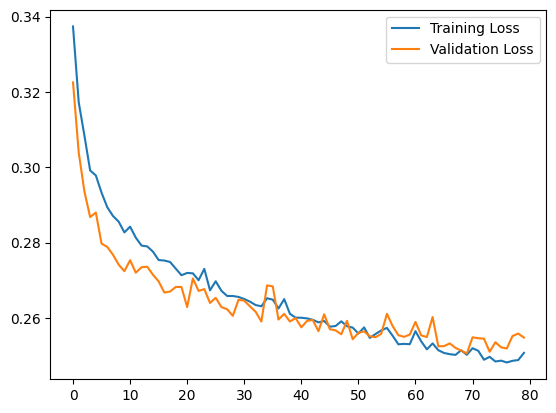

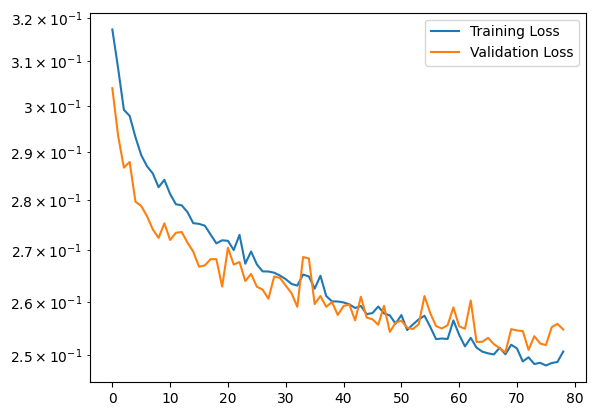

Mean: 8.98, RMSE: 213.66


In [263]:
num_epochs = 80
model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.001)
loss_list = []
validationloss_list = []
loss_fn = torch.nn.MSELoss()#torch.nn.L1Loss()

epochs_iter = np.arange(num_epochs)
for i in epochs_iter:
    print("Epoch:",i)

    # Within each iteration, we will go over each minibatch of data
    mini_i = 0
    for x_batch, y_batch in train_loader:
        mini_i += 1
        optimizer.zero_grad()
        
        output = model(x_batch[0])
        loss = loss_fn(output.flatten(), y_batch.flatten())

        loss.backward()
        optimizer.step()

        """
        if np.mod(mini_i, 200) == 0:
        
            train_loss = loss_fn(model(train_x.flatten(end_dim=1)).flatten(), train_y.flatten())
            loss_list.append(train_loss.item())

            validation_loss = loss_fn(model(validation_x.flatten(end_dim=1)).flatten(), validation_y.flatten())
            validationloss_list.append(validation_loss.item())

            print("Epoch: {}, minibatch {}, loss: {:.3f}, validation-loss: {:.3f}".format(i, mini_i,train_loss.item(), validation_loss.item()))
        """

    train_loss = loss_fn(model(train_x.flatten(end_dim=1)).flatten(), train_y.flatten())
    loss_list.append(train_loss.item())

    validation_loss = loss_fn(model(validation_x.flatten(end_dim=1)).flatten(), validation_y.flatten())
    validationloss_list.append(validation_loss.item())

    print("Epoch: {}, minibatch {}, loss: {:.3f}, validation-loss: {:.3f}".format(i, mini_i,train_loss.item(), validation_loss.item()))
plt.plot(loss_list, label="Training Loss")
plt.plot(validationloss_list, label="Validation Loss")
plt.legend()
plt.show()

plt.semilogy(loss_list[1:], label="Training Loss")
plt.semilogy(validationloss_list[1:], label="Validation Loss")
plt.legend()
plt.show()

test_prediction = model(test_x.flatten(end_dim=1)).flatten() * target_std + target_mean
test_err = test_prediction - (test_y.flatten() * target_std + target_mean)
mean = (test_err).mean()
rmse = ( ( test_err ) ** 2).mean().sqrt()
print("Mean: {:.2f}, RMSE: {:.2f}".format(mean, rmse))

# Do inference with the trained model

In [264]:

gebco = np.load("../data/raw/gebco.npy").astype(float)

land = np.copy(gebco)
land[land < 0] = np.nan

In [265]:
prediction_dataset = np.load("../data/processed/prediction.npy")

prediction_means = prediction_dataset.mean(axis=(0))
prediction_stds = prediction_dataset.std(axis=(0))
prediction_dataset = (prediction_dataset - data_means) / data_stds

prediction_dataset = torch.tensor(prediction_dataset, dtype=torch.float32)

In [ ]:
#predictions = model(prediction_dataset)

#predictions = torch.tensor([0.])
predictions = np.array([])

mini_i = 0
for x_batch in prediction_dataset:
    mini_i += 1
    #preds = likelihood(model(x_batch[0]))
    preds = model(x_batch[0])
    #preds = likelihood(model(x_batch[0]))#.to_data_independent_dist()
    #predictions = torch.cat([predictions, preds.flatten()])
    predictions = np.concatenate([predictions, preds.flatten().detach().numpy()])
    if np.mod(mini_i, 1) == 0:
        print("Prediction minibatch: {}/{}".format(mini_i, int(n_predict/n_batch)))

#predictions = predictions[1:]

In [267]:
topo_low = np.load("../data/raw/topo_low.npy")
predictions_full = (predictions.detach().numpy() * target_std + target_mean).reshape(topo_low.shape) + topo_low
#predictions_full[topo_low>0] = np.nan

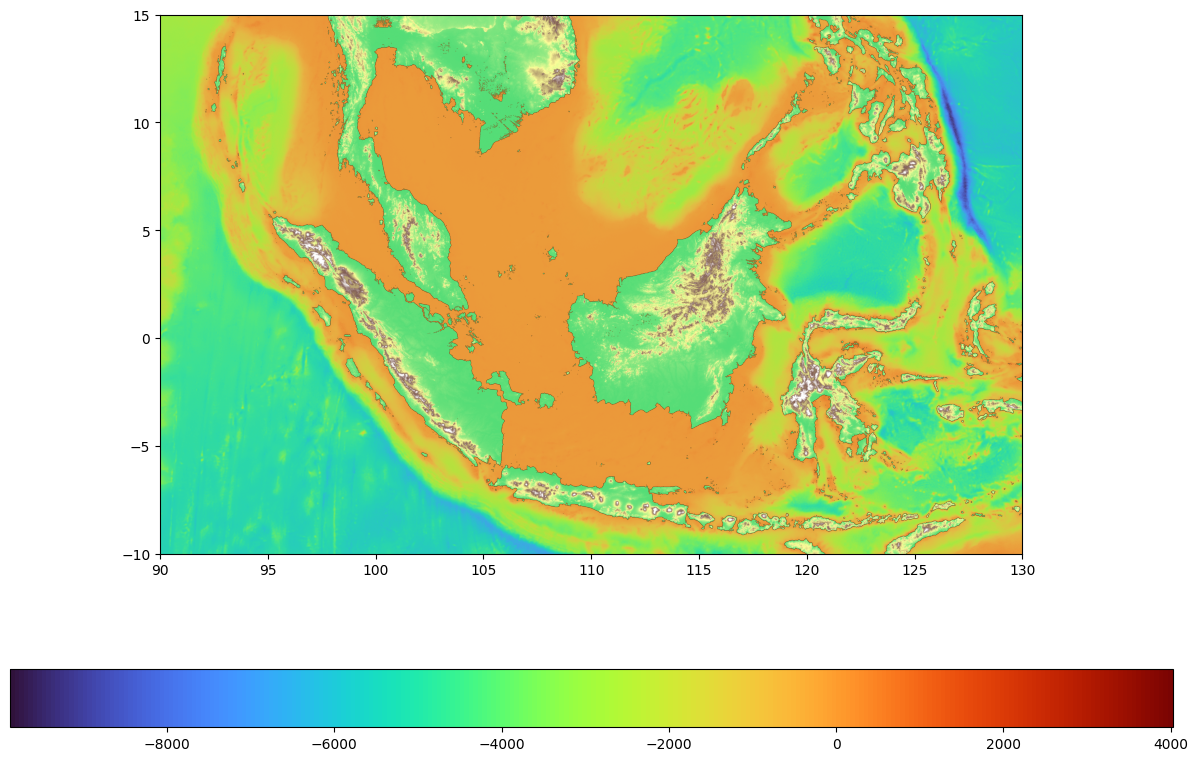

In [268]:
AOI = [90, 130, -10, 15] # Malaysia

plt.figure(figsize=(15,10))
sc=plt.imshow(predictions_full, extent=AOI, origin="lower", cmap="turbo")
shadex, shadey = np.gradient(predictions_full); shade = (shadex + shadey)/1e3
plt.imshow(shade, extent=AOI, origin="lower", cmap="gray", alpha=0.15, vmin=-10, vmax=10)
plt.imshow(land, extent=AOI, origin="lower", cmap="terrain", vmin=-1000, vmax=2000)
plt.colorbar(sc, orientation="horizontal")

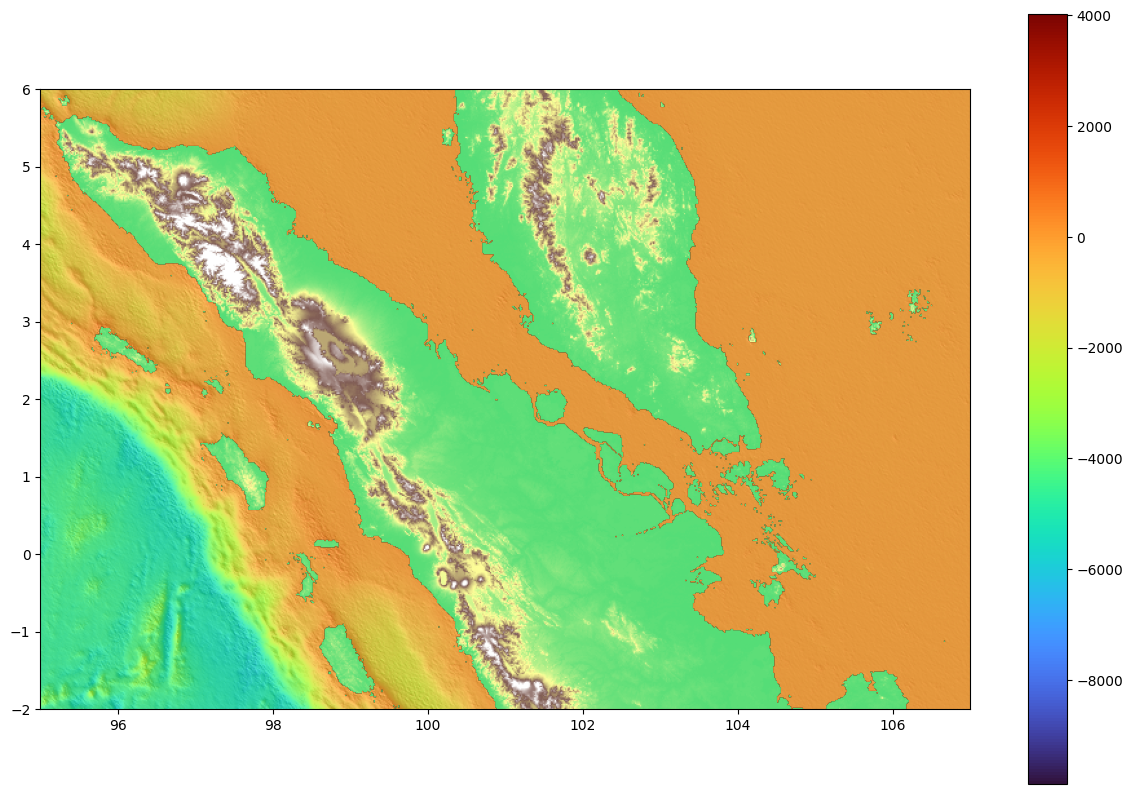

In [269]:

plt.figure(figsize=(15,10))
sc=plt.imshow(predictions_full, extent=AOI, origin="lower", cmap="turbo")
shadex, shadey = np.gradient(predictions_full); shade = (shadex + shadey)/1e3
plt.imshow(shade, extent=AOI, origin="lower", cmap="gray", alpha=0.2, vmin=-0.2, vmax=0.2)
plt.imshow(land, extent=AOI, origin="lower", cmap="terrain", vmin=-1000, vmax=2000)
plt.colorbar(sc, orientation="vertical")
plt.xlim([95, 107])
plt.ylim([-2, 6])
plt.show()

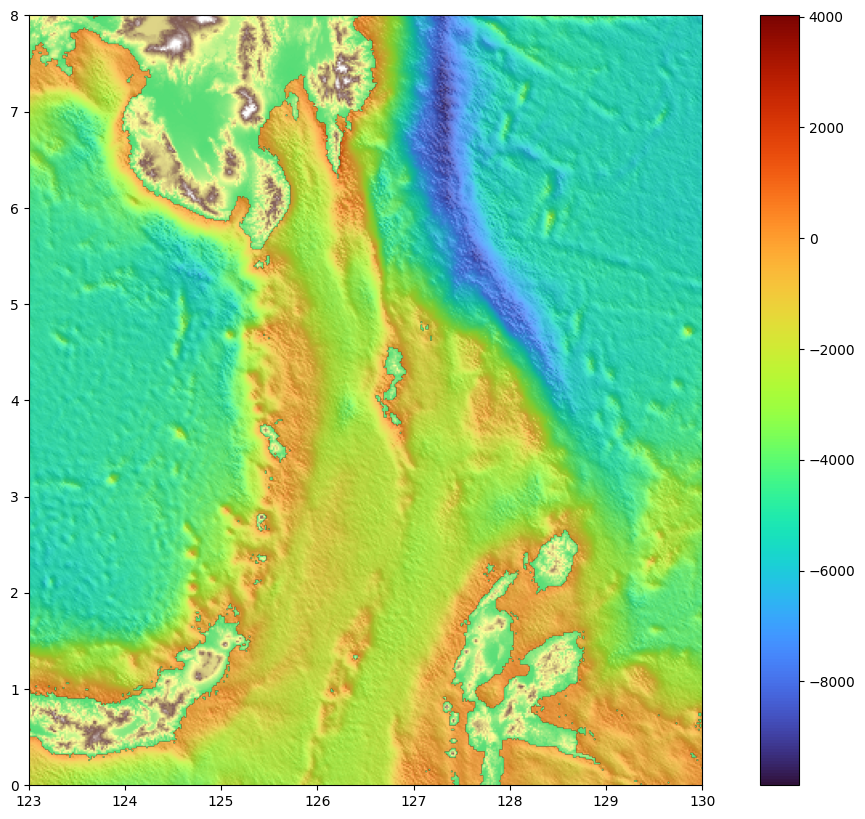

In [270]:

plt.figure(figsize=(15,10))
sc=plt.imshow(predictions_full, extent=AOI, origin="lower", cmap="turbo")
shadex, shadey = np.gradient(predictions_full); shade = (shadex + shadey)/1e3
plt.imshow(shade, extent=AOI, origin="lower", cmap="gray", alpha=0.2, vmin=-0.2, vmax=0.2)
plt.imshow(land, extent=AOI, origin="lower", cmap="terrain", vmin=-1000, vmax=2000)
plt.colorbar(sc, orientation="vertical")
plt.xlim([123, 130])
plt.ylim([0, 8])
plt.show()

Correlation 0.99
RMSE 219.07
Mean 15.33


/var/folders/zg/8bd6l0s17cd70scnh4g4blcr0000gp/T/ipykernel_78268/660044437.py:24: RuntimeWarning: divide by zero encountered in log10
  sc=ax.imshow(np.log10(hist[0].T), extent=[hist[1][0], hist[1][-1], hist[2][0], hist[2][-1]], origin="lower", cmap="turbo")


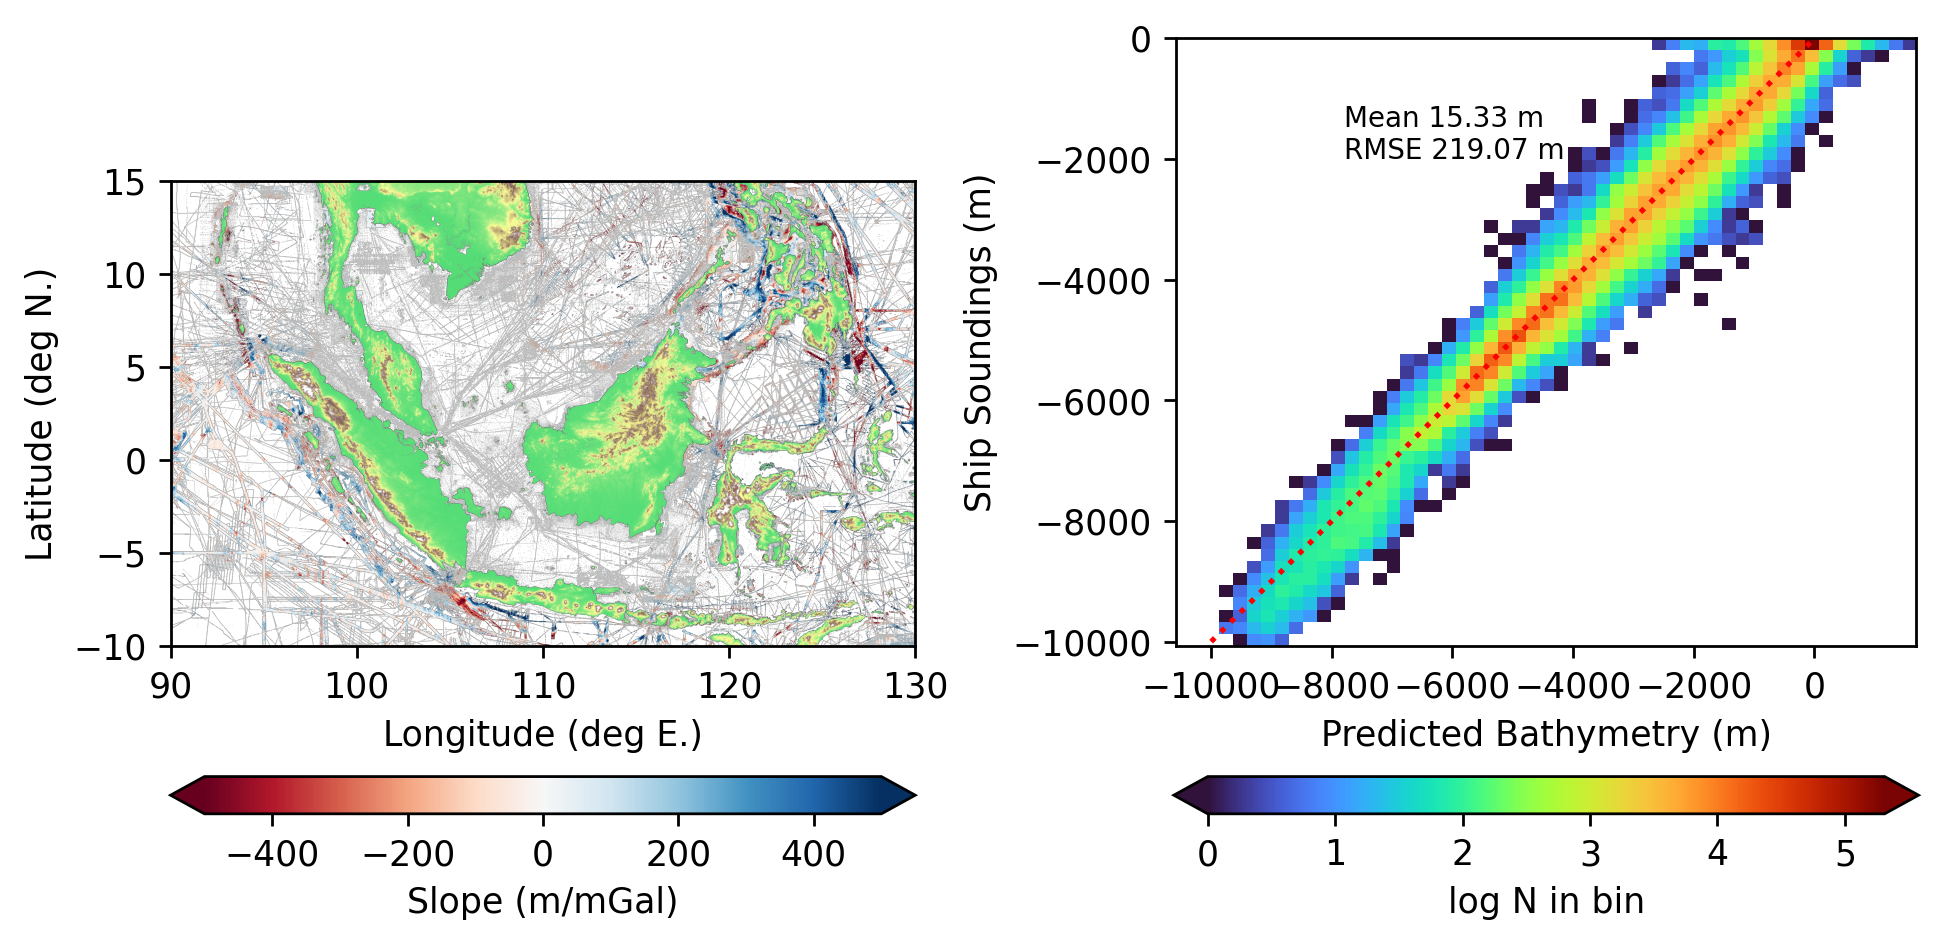

In [276]:

ship_high = np.load("../data/raw/ship.npy")
topo_low = np.load("../data/raw/topo_low.npy")
pred = predictions_full#.detach().numpy()

cm = 1/2.54
fig = plt.figure(figsize=(20*cm, 10*cm), dpi=250)

ax = fig.add_subplot(1,2,1)
sc=ax.imshow(pred-(ship_high+topo_low), extent=AOI, interpolation=None, origin="lower", vmin=-500, vmax=500, cmap="RdBu")
ax.imshow(land, extent=AOI, origin="lower", cmap="terrain", vmin=-1000, vmax=2000)
plt.colorbar(sc, orientation="horizontal", label="Slope (m/mGal)", extend="both")
ax.set_xlabel("Longitude (deg E.)")
ax.set_ylabel("Latitude (deg N.)")

ax = fig.add_subplot(1,2,2)
a = pred.reshape(-1)
b = ship_high.reshape(-1) + topo_low.reshape(-1)
mask = ~(np.isnan(a) | np.isnan(b))
print("Correlation {:.2f}".format(np.corrcoef(a[mask], b[mask])[0,1]))
err = a[mask] - b[mask]
print("RMSE {:.2f}".format(np.sqrt(np.mean(err**2))))
print("Mean {:.2f}".format(np.mean(err)))
hist = np.histogram2d(a[mask], b[mask], bins=50)
sc=ax.imshow(np.log10(hist[0].T), extent=[hist[1][0], hist[1][-1], hist[2][0], hist[2][-1]], origin="lower", cmap="turbo")
ax.set_aspect(1)
#ax.set_xlim([-3000, 0])
#ax.set_ylim([-3000, 3000])
ax.plot([-10_000, 0], [-10_000, 0], "r:")
ax.set_xlabel("Predicted Bathymetry (m)")
ax.set_ylabel("Ship Soundings (m)")
plt.colorbar(sc, orientation="horizontal", label="log N in bin", extend="both")
ax.text(-7800, -2000, "Mean {:.2f} m\nRMSE {:.2f} m".format(np.mean(err), np.sqrt(np.mean(err**2))), color="k", fontsize=8)
plt.tight_layout()
plt.show()